In [1]:
# Part 2: Real Estate Company Emissions Analysis
import os
os.environ['MALLOC_STRICT_SIZE'] = '0'
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import warnings
from prophet.diagnostics import cross_validation, performance_metrics
import logging
import sys
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from datetime import datetime
import statsmodels.api as sm
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import traceback

# Read the real estate company data
df_company = pd.read_csv('real_estate_company.csv')

# Display the original DataFrame
print("Original DataFrame:")
print(df_company)

# Check data info and types
print("\nDataFrame Info:")
print(df_company.info())

# Check for missing values
print("\nMissing Values:")
print(df_company.isnull().sum())

# Display summary statistics
print("\nSummary Statistics for Numeric Columns:")
print(df_company.describe())

Original DataFrame:
     Year  Month   Scope1  Scope2_Location  Scope2_Market  Scope3_Cat1  \
0    2015      1  2224.12          6256.33        5211.28     21844.76   
1    2015      2  2224.12          6256.33        5211.28     21844.76   
2    2015      3  2317.36          6509.81        5425.09     23079.21   
3    2015      4  2317.36          6750.69        5630.56     24012.81   
4    2015      5  2317.36          6991.58        5836.04     24946.41   
..    ...    ...      ...              ...            ...          ...   
115  2024      8  2747.61          8378.90        6703.12     17418.82   
116  2024      9  2640.97          7900.43        6321.24     16390.05   
117  2024     10  2640.97          7467.94        5974.35     15413.21   
118  2024     11  2465.09          6870.61        5496.49     14183.73   
119  2024     12  2465.09          4948.99        3959.19     10215.19   

     Scope3_Cat2  Scope3_Cat3  Scope3_Cat5  Scope3_Cat6  Scope3_Cat7  \
0       26222.26   

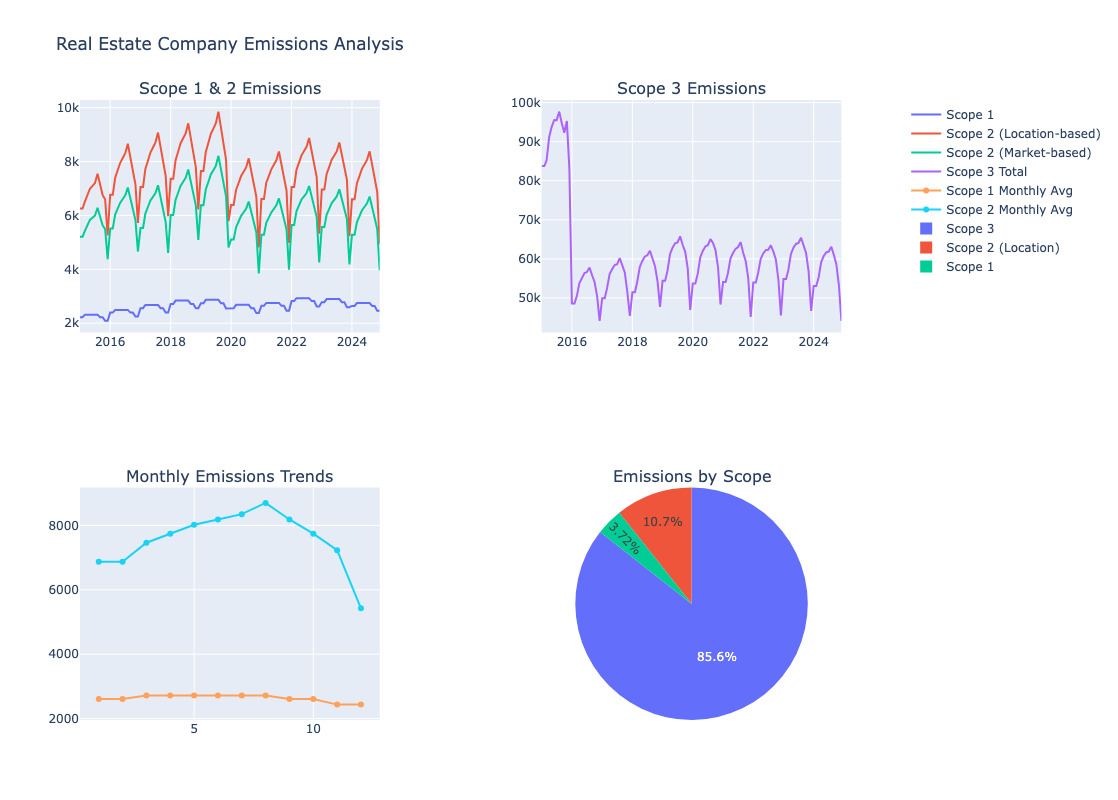


Correlation Analysis:

Correlation between Scope 1 and Scope 2 (Location-based):
0.6074374877250212

Correlation between Scope 1+2 and Scope 3:
0.025263663106340616

Year-over-Year Growth Rates:
scope1          0.020382
scope2_loc      0.012403
scope2_mkt      0.008659
scope3_total   -0.037423
dtype: float64

Key Findings:
1. Seasonal Patterns:
- Highest emissions month: 3 for Scope 1
- Highest emissions month: 8 for Scope 2

2. Scope Distribution:
- Scope 1: 3.7% of total emissions
- Scope 2 (Location): 10.7% of total emissions
- Scope 3: 85.6% of total emissions


In [2]:
emissions_ts = {}

# Create a datetime index from Year and Month columns
df_company['Date'] = pd.to_datetime(df_company[['Year', 'Month']].assign(Day=1))

# Create individual time series
emissions_ts['scope1'] = df_company.set_index('Date')['Scope1']
emissions_ts['scope2_loc'] = df_company.set_index('Date')['Scope2_Location']
emissions_ts['scope2_mkt'] = df_company.set_index('Date')['Scope2_Market']
emissions_ts['scope3_total'] = df_company.set_index('Date')[['Scope3_Cat1', 'Scope3_Cat2', 'Scope3_Cat3', 
                                                            'Scope3_Cat5', 'Scope3_Cat6', 'Scope3_Cat7',
                                                            'Scope3_Cat11', 'Scope3_Cat12', 'Scope3_Cat13',
                                                            'Scope3_Cat14']].sum(axis=1)

# Convert to DataFrame for easier plotting and analysis
emissions_df = pd.DataFrame(emissions_ts)

# 2. Create plots
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=('Scope 1 & 2 Emissions', 'Scope 3 Emissions',
                                  'Monthly Emissions Trends', 'Emissions by Scope'),
                    specs=[[{"secondary_y": True}, {"secondary_y": True}],
                          [{"secondary_y": True}, {"type": "domain"}]])  # Changed specs for pie chart

# Add traces for Scope 1 & 2
fig.add_trace(
    go.Scatter(x=emissions_df.index, y=emissions_df['scope1'], name="Scope 1"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=emissions_df.index, y=emissions_df['scope2_loc'], name="Scope 2 (Location-based)"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=emissions_df.index, y=emissions_df['scope2_mkt'], name="Scope 2 (Market-based)"),
    row=1, col=1
)

# Add trace for Scope 3
fig.add_trace(
    go.Scatter(x=emissions_df.index, y=emissions_df['scope3_total'], name="Scope 3 Total"),
    row=1, col=2
)

# Add monthly trends
monthly_avg = emissions_df.groupby(emissions_df.index.month).mean()
fig.add_trace(
    go.Scatter(x=monthly_avg.index, y=monthly_avg['scope1'], name="Scope 1 Monthly Avg"),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=monthly_avg.index, y=monthly_avg['scope2_loc'], name="Scope 2 Monthly Avg"),
    row=2, col=1
)

# Add emissions by scope pie chart
total_by_scope = {
    'Scope 1': emissions_df['scope1'].sum(),
    'Scope 2 (Location)': emissions_df['scope2_loc'].sum(),
    'Scope 3': emissions_df['scope3_total'].sum()
}
fig.add_trace(
    go.Pie(labels=list(total_by_scope.keys()), values=list(total_by_scope.values()), name="Emissions by Scope"),
    row=2, col=2
)

# Update layout
fig.update_layout(height=800, width=1200, title_text="Real Estate Company Emissions Analysis")
fig.show()
fig.write_image("2_company_images/company_dashboard_1.png")

# 3. Compute correlation matrices and insights
print("\nCorrelation Analysis:")
print("\nCorrelation between Scope 1 and Scope 2 (Location-based):")
print(emissions_df['scope1'].corr(emissions_df['scope2_loc']))

print("\nCorrelation between Scope 1+2 and Scope 3:")
scope12_loc = emissions_df['scope1'] + emissions_df['scope2_loc']
print(scope12_loc.corr(emissions_df['scope3_total']))

# Calculate year-over-year growth rates
annual_emissions = emissions_df.resample('Y').mean()
yoy_growth = annual_emissions.pct_change()

print("\nYear-over-Year Growth Rates:")
print(yoy_growth.mean())

print("\nKey Findings:")
print("1. Seasonal Patterns:")
print(f"- Highest emissions month: {monthly_avg['scope1'].idxmax()} for Scope 1")
print(f"- Highest emissions month: {monthly_avg['scope2_loc'].idxmax()} for Scope 2")

print("\n2. Scope Distribution:")
total_emissions = sum(total_by_scope.values())
for scope, value in total_by_scope.items():
    print(f"- {scope}: {value/total_emissions:.1%} of total emissions")

23:30:36 - cmdstanpy - INFO - Chain [1] start processing
23:30:36 - cmdstanpy - INFO - Chain [1] done processing
23:30:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:30:36 - cmdstanpy - INFO - Chain [1] start processing
23:30:55 - cmdstanpy - INFO - Chain [1] done processing
23:30:55 - cmdstanpy - INFO - Chain [1] start processing
23:30:55 - cmdstanpy - INFO - Chain [1] done processing
23:30:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:30:55 - cmdstanpy - INFO - Chain [1] start processing
23:30:56 - cmdstanpy - INFO - Chain [1] done processing
23:30:56 - cmdstanpy - INFO - Chain [1] start processing
23:30:56 - cmdstanpy - INFO - Chain [1] done processing
23:30:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

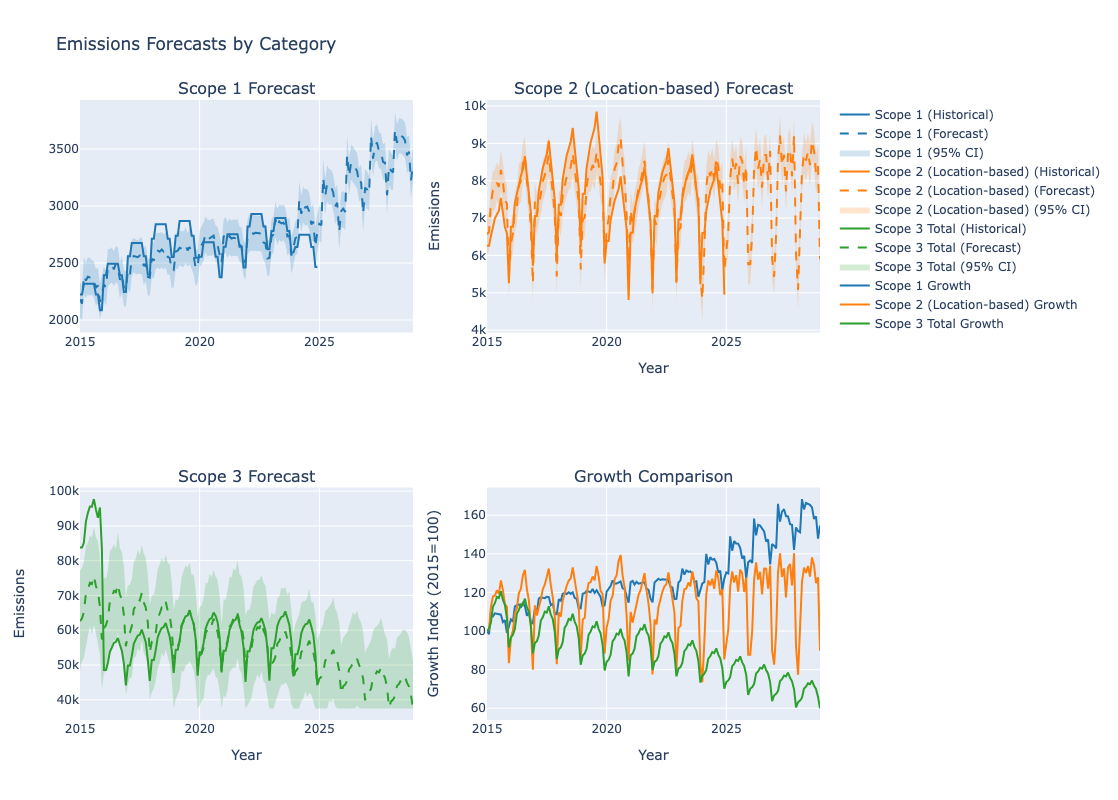


Forecast Results (2025-2027):
--------------------------------------------------------------------------------

Scope 1:
2024 Validation Metrics:
MAPE: 3.40%
RMSE: 90

Forecast Values:
2025: 2,831 (2,677 - 2,981)
2025: 3,250 (3,094 - 3,416)
2025: 3,087 (2,930 - 3,239)
2025: 3,196 (3,034 - 3,357)
2025: 3,169 (3,009 - 3,324)
2025: 3,167 (3,018 - 3,319)
2025: 3,119 (2,962 - 3,278)
2025: 2,998 (2,843 - 3,158)
2025: 3,029 (2,874 - 3,188)
2025: 2,771 (2,617 - 2,928)
2025: 2,955 (2,807 - 3,115)
2025: 2,977 (2,811 - 3,133)
2026: 2,948 (2,790 - 3,104)
2026: 3,450 (3,290 - 3,617)
2026: 3,260 (3,100 - 3,416)
2026: 3,379 (3,230 - 3,536)
2026: 3,371 (3,202 - 3,520)
2026: 3,340 (3,180 - 3,491)
2026: 3,305 (3,150 - 3,463)
2026: 3,191 (3,039 - 3,333)
2026: 3,213 (3,060 - 3,369)
2026: 2,933 (2,770 - 3,091)
2026: 3,161 (3,004 - 3,324)
2026: 3,143 (2,976 - 3,302)
2027: 3,112 (2,958 - 3,267)
2027: 3,617 (3,455 - 3,774)
2027: 3,415 (3,255 - 3,579)
2027: 3,529 (3,377 - 3,697)
2027: 3,556 (3,398 - 3,718)
20

In [3]:
# Function to create Prophet DataFrame
def create_prophet_df(data, category_name):
    return pd.DataFrame({
        'ds': pd.to_datetime(data.index, format='%Y'),
        'y': data.values
    })

# Function to fit Prophet model and generate forecast
def fit_and_forecast(df, periods=4, validation_year=2024, category_name=''):
    train_df = df[df['ds'].dt.year < validation_year].copy()
    test_df = df[df['ds'].dt.year == validation_year].copy()
    
    # Base configuration
    config = {
        'interval_width': 0.85,
        'weekly_seasonality': False,
        'daily_seasonality': False,
        'growth': 'linear',
        'seasonality_mode': 'multiplicative'
    }
    
    # Scope-specific configurations
    if 'Scope 1' in category_name:
        config.update({
            'yearly_seasonality': 8,
            'changepoint_prior_scale': 0.00001,
            'changepoint_range': 0.95,
            'seasonality_prior_scale': 1.0,
            'interval_width': 0.85
        })
    elif 'Scope 2' in category_name:
        config.update({
            'yearly_seasonality': 10,
            'changepoint_prior_scale': 0.00005,
            'changepoint_range': 0.95,
            'seasonality_prior_scale': 2.0,
            'interval_width': 0.85
        })
    else:  # Scope 3
        config.update({
            'yearly_seasonality': 5,
            'changepoint_prior_scale': 0.0005,
            'changepoint_range': 0.95,
            'seasonality_prior_scale': 0.5,
            'interval_width': 0.85
        })
    
    # Initialize Prophet with configured parameters
    model = Prophet(**config)
    
    # Add seasonality and regressors for Scope 1
    if 'Scope 1' in category_name:
        model.add_seasonality(
            name='monthly',
            period=30.5,
            fourier_order=3,
            prior_scale=0.5
        )
        
        # Add floorspace regressor if available in the data
        if 'floorspace' in train_df.columns:
            # Normalize floorspace
            floorspace_min = train_df['floorspace'].min()
            floorspace_max = train_df['floorspace'].max()
            train_df['floorspace_norm'] = (train_df['floorspace'] - floorspace_min) / (floorspace_max - floorspace_min)
            model.add_regressor('floorspace_norm', prior_scale=0.1)
        
        # Add recovery with reduced impact
        train_df['recovery'] = 0
        train_df.loc[train_df['ds'] >= '2021-01-01', 'recovery'] = 1
        model.add_regressor('recovery', prior_scale=0.01)
    else:
        # Original recovery handling for other scopes
        train_df['recovery'] = 0
        train_df.loc[train_df['ds'] >= '2021-01-01', 'recovery'] = 1
        recovery_prior = 0.2 if 'Scope 2' in category_name else 0.05
        model.add_regressor('recovery', prior_scale=recovery_prior)
    
    # Adjust floor
    df_min = train_df['y'].min()
    train_df['floor'] = df_min * 0.8
    
    # Fit the model
    model.fit(train_df)
    
    # Create future dataframe
    future = model.make_future_dataframe(periods=periods*12, freq='M')
    future['recovery'] = 0
    future.loc[future['ds'] >= '2021-01-01', 'recovery'] = 1
    
    # Add floorspace to future if it was used in training
    if 'floorspace_norm' in train_df.columns:
        last_floorspace = train_df['floorspace'].iloc[-1]
        future['floorspace_norm'] = (last_floorspace - floorspace_min) / (floorspace_max - floorspace_min)
    
    future['floor'] = df_min * 0.8
    
    # Generate forecast
    forecast = model.predict(future)
    
    # Ensure forecasts don't go below minimum historical value
    forecast['yhat'] = forecast['yhat'].clip(lower=df_min * 0.85)
    forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=df_min * 0.85)
    forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=df_min * 0.85)
    
    # Calculate metrics
    if len(test_df) > 0:
        y_true = test_df['y'].values[0]
        y_pred = forecast[forecast['ds'].dt.year == validation_year]['yhat'].values[0]
        mape = mean_absolute_percentage_error([y_true], [y_pred])
        rmse = np.sqrt(mean_squared_error([y_true], [y_pred]))
    else:
        mape = rmse = None
    
    return model, forecast, mape, rmse

# Create Prophet DataFrames with monthly data
scope1_df = create_prophet_df(emissions_ts['scope1'], 'Scope 1')
scope2_loc_df = create_prophet_df(emissions_ts['scope2_loc'], 'Scope 2 LB')
scope3_df = create_prophet_df(emissions_ts['scope3_total'], 'Scope 3')

# Fit models and generate forecasts
categories = {
    'Scope 1': scope1_df,
    'Scope 2 (Location-based)': scope2_loc_df,
    'Scope 3 Total': scope3_df
}

results = {}
for category_name, df in categories.items():
    model, forecast, mape, rmse = fit_and_forecast(df, periods=5, category_name=category_name)
    results[category_name] = {
        'forecast': forecast,
        'mape': mape,
        'rmse': rmse
    }

# Create visualization
fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=('Scope 1 Forecast', 'Scope 2 (Location-based) Forecast',
                                  'Scope 3 Forecast', 'Growth Comparison'),
                    specs=[[{}, {}], [{}, {}]])

# Define colors with transparency
colors = {
    'Scope 1': {'line': 'rgb(31, 119, 180)', 'fill': 'rgba(31, 119, 180, 0.2)'},
    'Scope 2 (Location-based)': {'line': 'rgb(255, 127, 14)', 'fill': 'rgba(255, 127, 14, 0.2)'},
    'Scope 3 Total': {'line': 'rgb(44, 160, 44)', 'fill': 'rgba(44, 160, 44, 0.2)'}
}

# Plot each forecast
for idx, (category_name, result) in enumerate(results.items()):
    forecast = result['forecast']
    row = (idx // 2) + 1
    col = (idx % 2) + 1
    
    if idx < 3:  # Individual forecasts
        # Historical data
        fig.add_trace(
            go.Scatter(x=categories[category_name]['ds'], 
                      y=categories[category_name]['y'],
                      name=f'{category_name} (Historical)',
                      line=dict(color=colors[category_name]['line'])),
            row=row, col=col
        )
        
        # Forecast
        fig.add_trace(
            go.Scatter(x=forecast['ds'], 
                      y=forecast['yhat'],
                      name=f'{category_name} (Forecast)',
                      line=dict(color=colors[category_name]['line'], dash='dash')),
            row=row, col=col
        )
        
        # Confidence intervals
        fig.add_trace(
            go.Scatter(x=forecast['ds'].tolist() + forecast['ds'].tolist()[::-1],
                      y=forecast['yhat_upper'].tolist() + forecast['yhat_lower'].tolist()[::-1],
                      fill='toself',
                      fillcolor=colors[category_name]['fill'],
                      line=dict(color='rgba(255,255,255,0)'),
                      name=f'{category_name} (95% CI)'),
            row=row, col=col
        )

# Add normalized growth comparison
base_year = 2015
for category_name, result in results.items():
    forecast = result['forecast']
    normalized = forecast['yhat'] / forecast[forecast['ds'].dt.year == base_year]['yhat'].iloc[0] * 100
    fig.add_trace(
        go.Scatter(x=forecast['ds'],
                  y=normalized,
                  name=f'{category_name} Growth',
                  line=dict(color=colors[category_name]['line'])),
        row=2, col=2
    )

# Update layout
fig.update_layout(height=800, width=1200,
                 title_text="Emissions Forecasts by Category",
                 showlegend=True)

# Update axes labels
for i in range(1, 4):
    row = (i // 2) + 1
    col = (i % 2) + 1
    fig.update_xaxes(title_text="Year", row=row, col=col)
    fig.update_yaxes(title_text="Emissions", row=row, col=col)

fig.update_xaxes(title_text="Year", row=2, col=2)
fig.update_yaxes(title_text="Growth Index (2015=100)", row=2, col=2)

fig.show()
fig.write_image("2_company_images/company_dashboard_2.png")

# Print forecasts and metrics
print("\nForecast Results (2025-2027):")
print("-" * 80)
for category_name, result in results.items():
    forecast = result['forecast']    
    future_years = forecast[forecast['ds'].dt.year >= 2025]
    
    print(f"\n{category_name}:")
    print(f"2024 Validation Metrics:")
    print(f"MAPE: {result['mape']:.2%}")
    print(f"RMSE: {result['rmse']:,.0f}")
    
    print("\nForecast Values:")
    for _, row in future_years.iterrows():
        print(f"{row['ds'].year}: {row['yhat']:,.0f} ({row['yhat_lower']:,.0f} - {row['yhat_upper']:,.0f})")

# Calculate and print growth rates with error handling
print("\nCompound Annual Growth Rates (2024-2027):")
for category_name, result in results.items():
    forecast = result['forecast']
    try:
        start_value = forecast[forecast['ds'].dt.year == 2024]['yhat'].values[0]
        end_value = forecast[forecast['ds'].dt.year == 2027]['yhat'].values[0]
        cagr = (end_value / start_value) ** (1/3) - 1
        print(f"{category_name}: {cagr:.1%}")
    except IndexError:
        print(f"Warning: Could not calculate CAGR for {category_name}")
        print(f"Available years: {sorted(forecast['ds'].dt.year.unique())}")

print("\nKey Insights:")
print("1. Growth Trends:")
# Compare growth rates and identify steepest growth
growth_rates = {}
for category_name, result in results.items():
    forecast = result['forecast']
    start_value = forecast[forecast['ds'].dt.year == 2024]['yhat'].values[0]
    end_value = forecast[forecast['ds'].dt.year == 2027]['yhat'].values[0]
    growth_rates[category_name] = (end_value / start_value) ** (1/3) - 1

steepest_growth = max(growth_rates.items(), key=lambda x: x[1])
print(f"- {steepest_growth[0]} shows the steepest growth at {steepest_growth[1]:.1%} CAGR")

print("\n2. Forecast Uncertainty:")
for category_name, result in results.items():
    forecast = result['forecast']
    uncertainty = (forecast['yhat_upper'] - forecast['yhat_lower']) / forecast['yhat']
    avg_uncertainty = uncertainty[forecast['ds'].dt.year > 2024].mean()
    print(f"- {category_name}: Average forecast uncertainty band is {avg_uncertainty:.1%}")

print("\n3. Model Performance:")
best_mape = min(results.items(), key=lambda x: x[1]['mape'])
print(f"- {best_mape[0]} shows the most accurate predictions with MAPE of {best_mape[1]['mape']:.2%}")

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency info


SARIMAX Forecast Results (2024-2026):
--------------------------------------------------------------------------------

scope1:
2024 Validation Metrics:
MAPE: 2.36%
RMSE: 62

Forecast Values:
2024: 2,703 (2,666 - 2,740)
2025: 2,703 (2,651 - 2,755)
2026: 2,824 (2,757 - 2,891)

scope2_loc:
2024 Validation Metrics:
MAPE: 5.13%
RMSE: 339

Forecast Values:
2024: 6,941 (6,715 - 7,168)
2025: 6,936 (6,563 - 7,308)
2026: 7,521 (7,032 - 8,010)

scope3_total:
2024 Validation Metrics:
MAPE: 4.90%
RMSE: 2,602

Forecast Values:
2024: 55,664 (54,726 - 56,601)
2025: 55,701 (54,328 - 57,073)
2026: 58,013 (56,338 - 59,688)

Model Comparison (2024 Validation):
--------------------------------------------------------------------------------

Scope 1:
Prophet - MAPE: 3.40%, RMSE: 90
SARIMAX - MAPE: 2.36%, RMSE: 62
Better model based on MAPE: SARIMAX

Scope 2 (Location-based):
Prophet - MAPE: 6.32%, RMSE: 417
SARIMAX - MAPE: 5.13%, RMSE: 339
Better model based on MAPE: SARIMAX

Scope 3 Total:
Prophet - MAP

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



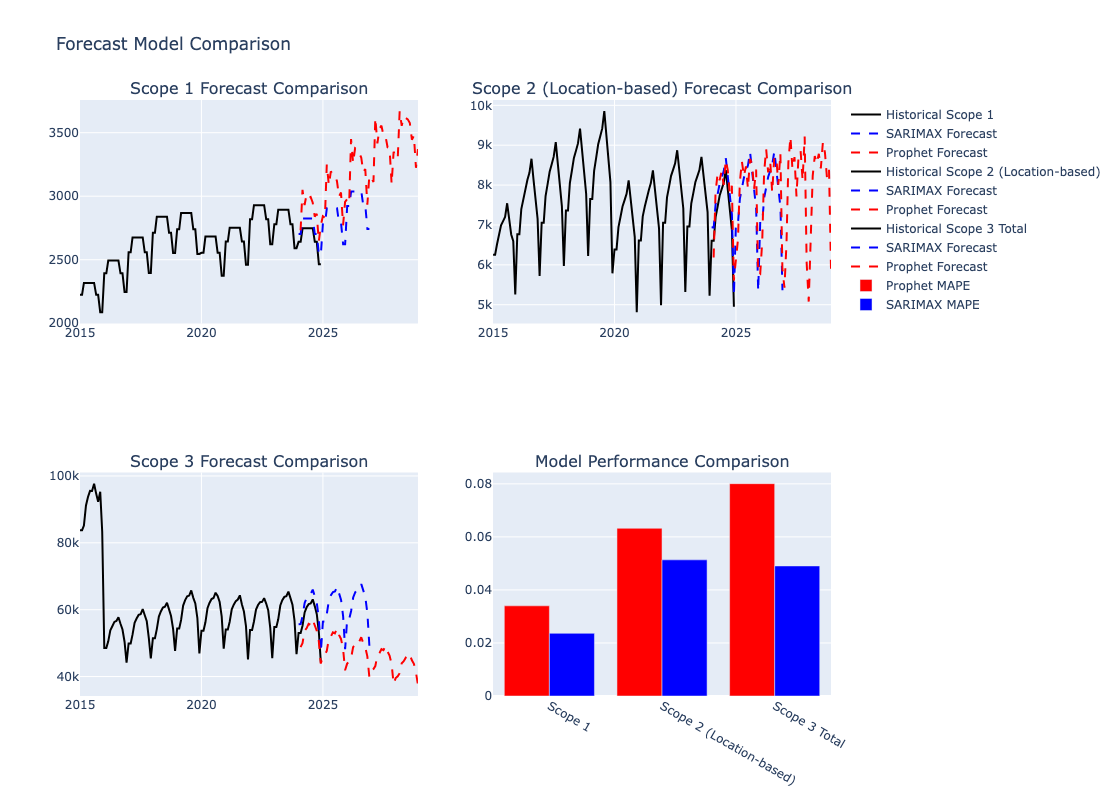

In [4]:
def fit_sarimax_and_forecast(data, category_name, validation_year=2024):
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index, format='%Y')
    
    train = data[data.index.year < validation_year]
    test = data[data.index.year == validation_year]
    
    # Add seasonal orders and try more combinations
    orders = [(1,1,1), (2,1,2), (1,1,2)]
    seasonal_orders = [(1,1,1,12), (2,1,1,12)]  # Add seasonal components
    
    best_aic = np.inf
    best_model = None
    
    for order in orders:
        for seasonal_order in seasonal_orders:
            try:
                model = SARIMAX(train,
                              order=order,
                              seasonal_order=seasonal_order,
                              enforce_stationarity=False,
                              enforce_invertibility=False)
                results = model.fit(disp=False)  # Suppress convergence messages
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_model = results
            except:
                continue
    
    if best_model is None:
        raise ValueError("No valid model found")
    
    # Generate forecasts
    forecast = best_model.get_forecast(steps=36)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int(alpha=0.2)  # Tighter confidence intervals (80%)
    
    # Calculate metrics
    if len(test) > 0:
        y_true = test.values[0]
        y_pred = forecast_mean.values[0]
        mape = mean_absolute_percentage_error([y_true], [y_pred])
        rmse = np.sqrt(mean_squared_error([y_true], [y_pred]))
    else:
        mape = rmse = None
    
    return {
        'forecast': forecast_mean,
        'conf_int': forecast_ci,
        'mape': mape,
        'rmse': rmse,
        'model': best_model
    }

# Fit SARIMAX models for each category
sarimax_results = {}
categories_to_forecast = ['scope1', 'scope2_loc', 'scope3_total']

for category_name in categories_to_forecast:
    if category_name in emissions_ts:
        ts = emissions_ts[category_name]
        sarimax_results[category_name] = fit_sarimax_and_forecast(ts, category_name)

# Print results and compare with Prophet
print("\nSARIMAX Forecast Results (2024-2026):")
print("-" * 80)
for category_name, result in sarimax_results.items():
    print(f"\n{category_name}:")
    print(f"2024 Validation Metrics:")
    print(f"MAPE: {result['mape']:.2%}" if result['mape'] is not None else "MAPE: N/A")
    print(f"RMSE: {result['rmse']:,.0f}" if result['rmse'] is not None else "RMSE: N/A")
    
    print("\nForecast Values:")
    for year, (forecast, (lower, upper)) in zip(range(2024, 2027),
                                              zip(result['forecast'],
                                                  result['conf_int'].values)):
        print(f"{year}: {forecast:,.0f} ({lower:,.0f} - {upper:,.0f})")

# Compare with Prophet results
print("\nModel Comparison (2024 Validation):")
print("-" * 80)
categories_map = {
    'scope1': 'Scope 1',
    'scope2_loc': 'Scope 2 (Location-based)',
    'scope3_total': 'Scope 3 Total'
}

for category_name, nice_name in categories_map.items():
    if category_name in sarimax_results:
        prophet_mape = results[nice_name]['mape']
        prophet_rmse = results[nice_name]['rmse']
        sarimax_mape = sarimax_results[category_name]['mape']
        sarimax_rmse = sarimax_results[category_name]['rmse']
        
        print(f"\n{nice_name}:")
        print(f"Prophet - MAPE: {prophet_mape:.2%}, RMSE: {prophet_rmse:,.0f}")
        print(f"SARIMAX - MAPE: {sarimax_mape:.2%}, RMSE: {sarimax_rmse:,.0f}")
        
        if sarimax_mape is not None and prophet_mape is not None:
            better_model = "Prophet" if prophet_mape < sarimax_mape else "SARIMAX"
            print(f"Better model based on MAPE: {better_model}")

# Visualize the comparison
fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=('Scope 1 Forecast Comparison', 
                                  'Scope 2 (Location-based) Forecast Comparison',
                                  'Scope 3 Forecast Comparison', 
                                  'Model Performance Comparison'))

# Add forecasts for each category
for idx, (category, nice_name) in enumerate(categories_map.items()):
    if category not in sarimax_results:
        continue
        
    row = (idx // 2) + 1
    col = (idx % 2) + 1
    
    # Historical data
    fig.add_trace(
        go.Scatter(x=emissions_ts[category].index, 
                  y=emissions_ts[category].values,
                  name=f'Historical {nice_name}',
                  line=dict(color='black')),
        row=row, col=col
    )
    
    # SARIMAX forecast
    sarimax_forecast = sarimax_results[category]['forecast']
    sarimax_ci = sarimax_results[category]['conf_int']
    
    fig.add_trace(
        go.Scatter(x=sarimax_forecast.index, 
                  y=sarimax_forecast.values,
                  name=f'SARIMAX Forecast',
                  line=dict(color='blue', dash='dash')),
        row=row, col=col
    )
    
    # Prophet forecast (from previous results)
    prophet_forecast = results[nice_name]['forecast']
    prophet_future = prophet_forecast[prophet_forecast['ds'].dt.year >= 2024]
    
    fig.add_trace(
        go.Scatter(x=prophet_future['ds'], 
                  y=prophet_future['yhat'],
                  name=f'Prophet Forecast',
                  line=dict(color='red', dash='dash')),
        row=row, col=col
    )

# Add MAPE comparison bar chart
mapes = {
    'Prophet': [results[name]['mape'] for name in categories_map.values()],
    'SARIMAX': [sarimax_results[cat]['mape'] for cat in categories_map.keys() if cat in sarimax_results]
}

fig.add_trace(
    go.Bar(x=list(categories_map.values()),
           y=mapes['Prophet'],
           name='Prophet MAPE',
           marker_color='red'),
    row=2, col=2
)

fig.add_trace(
    go.Bar(x=list(categories_map.values()),
           y=mapes['SARIMAX'],
           name='SARIMAX MAPE',
           marker_color='blue'),
    row=2, col=2
)

fig.update_layout(height=800, width=1200,
                 title_text="Forecast Model Comparison",
                 showlegend=True)

fig.show()
fig.write_image("2_company_images/company_dashboard_4.png")

/var/folders/pw/wl4sd_5n1vz4w76rnj88m6l00000gq/T/ipykernel_21321/340171388.py:43: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.




Validation Metrics (Rolling Window):
MAPE: 4.03%
RMSE: 131

Validation Metrics (Last Year):
R² Score: nan
MAPE: 2.13%
RMSE: 52

Forecast Results (2024-2026):
2024: 2,632
2025: 2,633
2026: 2,633

Model Comparison (Validation):
--------------------------------------------------------------------------------
XGBoost:
MAPE: 2.13%
RMSE: 52

Prophet:
MAPE: 3.40%
RMSE: 90

SARIMAX:
MAPE: 2.36%
RMSE: 62


/var/folders/pw/wl4sd_5n1vz4w76rnj88m6l00000gq/T/ipykernel_21321/340171388.py:43: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



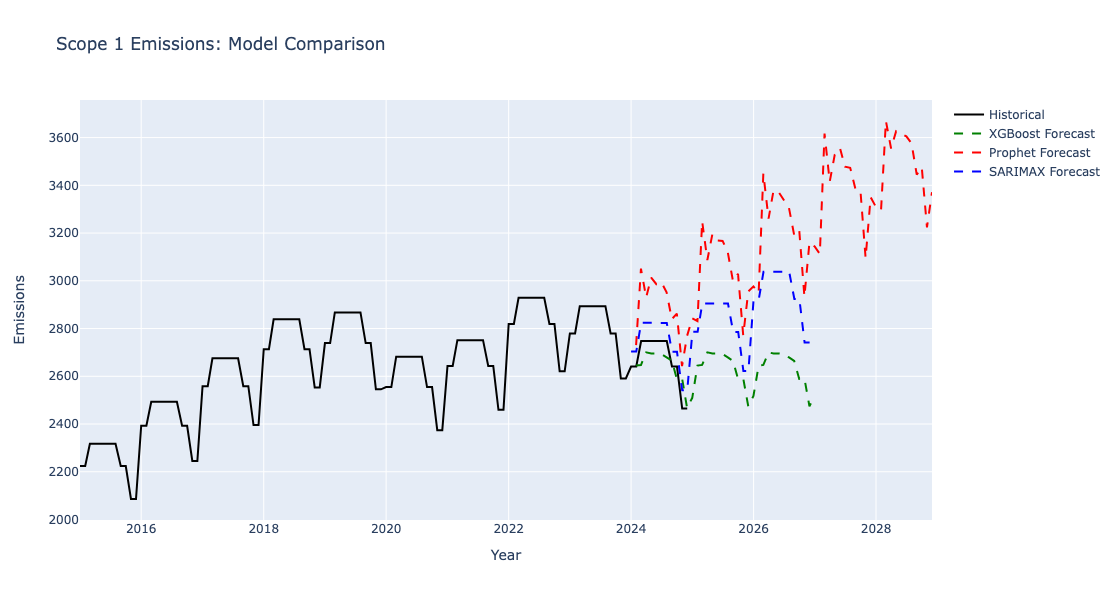


Feature Importance:
             feature  importance
2         floorspace    0.310485
6         year_trend    0.248404
0               year    0.171875
8          month_cos    0.130367
1              month    0.087873
3   carbon_intensity    0.030925
7          month_sin    0.020070
4     emissions_lag3    0.000000
5     emissions_lag6    0.000000
9          growth_3m    0.000000
10         growth_6m    0.000000


In [5]:
def prepare_emissions_ts(df):
    # Create datetime index
    df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
    df = df.set_index('date')
    
    # Create the emissions_ts dictionary with all required series
    emissions_ts = {
        'scope1': df['Scope1'],
        'scope2_location': df['Scope2_Location'],
        'scope2_market': df['Scope2_Market'],
        'floorspace': df['floorspace'],  # Using the column name from CSV
        'carbon_intensity': (df['Scope1'] + df['Scope2_Location']) / df['floorspace']  # Calculate intensity
    }
    
    return emissions_ts

def prepare_features(emissions_ts, category='scope1', include_lag=True):
    df = pd.DataFrame({
        'year': emissions_ts[category].index.year,
        'month': emissions_ts[category].index.month,
        'emissions': emissions_ts[category].values,
        'floorspace': emissions_ts['floorspace'].values,
        'carbon_intensity': emissions_ts['carbon_intensity'].values
    })
    
    # Use shorter lags (3 and 6 months instead of 12)
    if include_lag:
        df['emissions_lag3'] = emissions_ts[category].shift(3)
        df['emissions_lag6'] = emissions_ts[category].shift(6)
    
    # Strengthen trend and seasonal features
    df['year_trend'] = (df['year'] - df['year'].min()) / (df['year'].max() - df['year'].min())
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    
    # Add growth rates with shorter windows
    df['growth_3m'] = emissions_ts[category].pct_change(periods=3)
    df['growth_6m'] = emissions_ts[category].pct_change(periods=6)
    
    # Fill NaN values
    for col in df.columns:
        if col != 'emissions':
            df[col] = df[col].fillna(method='bfill').fillna(method='ffill')
    
    return df

# Modified XGBoost parameters to reduce overfitting
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.7,  # Reduce feature sampling to force diversity
    gamma=0.5,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)

# Create feature matrix and target vector
def create_xy(df, target_col='emissions'):
    y = df[target_col]
    X = df.drop(columns=[target_col])
    return X, y

# Function to make future predictions
def create_future_features(emissions_ts, last_emissions, years_to_forecast=3):
    last_year = int(emissions_ts['scope1'].index.max().year)
    future_years = range(last_year + 1, last_year + years_to_forecast + 1)
    
    # Calculate historical patterns
    historical_data = emissions_ts['scope1']
    
    # Calculate average annual growth rate from historical data
    annual_growth = (historical_data.iloc[-1] / historical_data.iloc[0]) ** (1/len(historical_data.index.year.unique())) - 1
    
    # Calculate seasonal patterns
    monthly_averages = historical_data.groupby(historical_data.index.month).mean()
    seasonal_factors = monthly_averages / monthly_averages.mean()
    
    # Calculate trend volatility
    historical_volatility = historical_data.pct_change().std()
    
    future_records = []
    last_value = last_emissions
    
    for year in future_years:
        base_growth = (1 + annual_growth) ** (year - last_year)
        
        for month in range(1, 13):
            # Apply seasonal adjustment with reduced amplitude
            seasonal_factor = 1 + (seasonal_factors[month] - 1) * 0.5  # Reduce seasonal amplitude by 50%
            
            # Add small random variation based on historical volatility
            random_factor = 1 + np.random.normal(0, historical_volatility * 0.3)  # Reduce volatility by 70%
            
            # Calculate projected value
            projected_value = last_emissions * base_growth * seasonal_factor * random_factor
            
            future_records.append({
                'year': year,
                'month': month,
                'floorspace': emissions_ts['floorspace'].iloc[-1] * (1.02) ** (year - last_year),
                'carbon_intensity': emissions_ts['carbon_intensity'].iloc[-1],
                'year_trend': (year - last_year + 1) / years_to_forecast,
                'month_sin': np.sin(2 * np.pi * month/12),
                'month_cos': np.cos(2 * np.pi * month/12),
                'emissions_lag3': last_value,
                'emissions_lag6': emissions_ts['scope1'].iloc[-6] if len(emissions_ts['scope1']) >= 6 else last_value,
                'growth_3m': historical_data.pct_change(periods=3).mean(),
                'growth_6m': historical_data.pct_change(periods=6).mean()
            })
            
            last_value = projected_value
    
    future_df = pd.DataFrame(future_records)
    
    # Ensure columns are in the same order as training data
    feature_order = [
        'year', 'month', 'floorspace', 'carbon_intensity', 
        'emissions_lag3', 'emissions_lag6', 'year_trend',
        'month_sin', 'month_cos', 'growth_3m', 'growth_6m'
    ]
    future_df = future_df[feature_order]
    
    return future_df

def train_and_predict_rolling(emissions_ts, category='scope1', n_splits=5):
    # Prepare features for the entire dataset
    df = prepare_features(emissions_ts, category, include_lag=True)
    
    # Create TimeSeriesSplit object
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Initialize lists to store validation results
    val_predictions = []
    val_actuals = []
    
    # Create feature matrix and target vector
    X, y = create_xy(df)
    
    # Perform rolling window cross-validation
    for train_idx, val_idx in tscv.split(X):
        # Split data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train model with adjusted parameters
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=300,
            learning_rate=0.1,
            max_depth=4,
            min_child_weight=2,
            subsample=0.8,
            colsample_bytree=0.7,
            gamma=0.3,
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=42
        )
        
        model.fit(X_train, y_train)
        
        # Make predictions
        val_pred = model.predict(X_val)
        
        # Store results
        val_predictions.extend(val_pred)
        val_actuals.extend(y_val)
    
    # Calculate validation metrics
    val_mape = mean_absolute_percentage_error(val_actuals, val_predictions)
    val_rmse = np.sqrt(mean_squared_error(val_actuals, val_predictions))
    
    # Train final model on all data for future predictions
    final_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=300,
        learning_rate=0.1,
        max_depth=4,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.7,
        gamma=0.3,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42
    )
    
    final_model.fit(X, y)
    
    # Create and predict future values
    future_df = create_future_features(emissions_ts, df['emissions'].iloc[-1])
    future_predictions = []
    
    # Iteratively predict future values
    for i in range(len(future_df)):
        pred = final_model.predict(future_df.iloc[[i]])[0]
        future_predictions.append(pred)
        if i < len(future_df) - 1:
            # Update lag features
            if i + 3 < len(future_df):
                future_df.iloc[i + 3, future_df.columns.get_loc('emissions_lag3')] = pred
            if i + 6 < len(future_df):
                future_df.iloc[i + 6, future_df.columns.get_loc('emissions_lag6')] = pred
            
            # Update growth rates
            if i > 2:
                future_df.iloc[i + 1, future_df.columns.get_loc('growth_3m')] = (
                    (pred / future_predictions[i-3] - 1) if future_predictions[i-3] != 0 else 0
                )
            if i > 5:
                future_df.iloc[i + 1, future_df.columns.get_loc('growth_6m')] = (
                    (pred / future_predictions[i-6] - 1) if future_predictions[i-6] != 0 else 0
                )
    
    return future_predictions, val_mape, val_rmse, final_model

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,              # Increased from 200
    learning_rate=0.1,             # Increased from 0.05
    max_depth=4,
    min_child_weight=2,            # Reduced from 3
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=0.3,                     # Reduced from 0.5
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)

# Main execution code
# Main execution code
df = pd.read_csv('real_estate_company.csv')
emissions_ts = prepare_emissions_ts(df)

# Run the rolling window prediction
future_predictions, val_mape, val_rmse, final_model = train_and_predict_rolling(emissions_ts, 'scope1')

# Print rolling window results
print("\nValidation Metrics (Rolling Window):")
print(f"MAPE: {val_mape:.2%}")
print(f"RMSE: {val_rmse:.0f}")

# Prepare the data for last year validation
df = prepare_features(emissions_ts, 'scope1', include_lag=True)
if len(df) < 2:
    raise ValueError("Not enough data points after preparation")

# Split into training and validation sets (use last year as validation)
train_df = df.iloc[:-1]
val_df = df.iloc[-1:]

if len(train_df) == 0 or len(val_df) == 0:
    raise ValueError("Empty training or validation set after splitting")

X_train, y_train = create_xy(train_df)
X_val, y_val = create_xy(val_df)

# Initialize and fit the model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.1,
    max_depth=4,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=0.3,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)
model.fit(X_train, y_train)

# Make validation predictions
val_pred = model.predict(X_val)

# Calculate metrics for validation
if len(y_val) > 0 and len(val_pred) > 0:
    val_r2 = r2_score(y_val, val_pred)
    val_mape = mean_absolute_percentage_error(y_val, val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
else:
    raise ValueError("Empty validation set or predictions")

print("\nValidation Metrics (Last Year):")
print(f"R² Score: {val_r2:.4f}")
print(f"MAPE: {val_mape:.2%}")
print(f"RMSE: {val_rmse:,.0f}")

# Create and print future predictions
future_df = create_future_features(emissions_ts, df['emissions'].iloc[-1])
future_predictions = []

# Iteratively predict future values
for i in range(len(future_df)):
    pred = model.predict(future_df.iloc[[i]])[0]
    future_predictions.append(pred)
    if i < len(future_df) - 1:
        # Update lag features and growth rates
        if i + 3 < len(future_df):
            future_df.iloc[i + 3, future_df.columns.get_loc('emissions_lag3')] = pred
        if i + 6 < len(future_df):
            future_df.iloc[i + 6, future_df.columns.get_loc('emissions_lag6')] = pred
        
        # Update growth rates if needed
        if i > 2:  # Can calculate 3-month growth
            future_df.iloc[i + 1, future_df.columns.get_loc('growth_3m')] = (
                (pred / future_predictions[i-3] - 1) if future_predictions[i-3] != 0 else 0
            )
        if i > 5:  # Can calculate 6-month growth
            future_df.iloc[i + 1, future_df.columns.get_loc('growth_6m')] = (
                (pred / future_predictions[i-6] - 1) if future_predictions[i-6] != 0 else 0
            )

# Print forecast results (only once)
print("\nForecast Results (2024-2026):")
years = range(2024, 2027)
monthly_preds = np.array_split(future_predictions, len(years))
for year, preds in zip(years, monthly_preds):
    print(f"{year}: {np.mean(preds):,.0f}")

# Compare with Prophet and ARIMA results
print("\nModel Comparison (Validation):")
print("-" * 80)
print("XGBoost:")
print(f"MAPE: {val_mape:.2%}")
print(f"RMSE: {val_rmse:,.0f}")
print("\nProphet:")
print(f"MAPE: {results['Scope 1']['mape']:.2%}")
print(f"RMSE: {results['Scope 1']['rmse']:,.0f}")
print("\nSARIMAX:")
print(f"MAPE: {sarimax_results['scope1']['mape']:.2%}")
print(f"RMSE: {sarimax_results['scope1']['rmse']:,.0f}")

# Visualize the results
fig = go.Figure()

# Historical data
fig.add_trace(
    go.Scatter(
        x=emissions_ts['scope1'].index,
        y=emissions_ts['scope1'].values,
        name='Historical',
        line=dict(color='black')
    )
)

# XGBoost forecast
fig.add_trace(
    go.Scatter(
        x=pd.date_range(start='2024-01-01', periods=len(future_predictions), freq='M'),
        y=future_predictions,
        name='XGBoost Forecast',
        line=dict(color='green', dash='dash')
    )
)

# Prophet forecast
prophet_future = results['Scope 1']['forecast'][results['Scope 1']['forecast']['ds'].dt.year >= 2024]
fig.add_trace(
    go.Scatter(
        x=prophet_future['ds'],
        y=prophet_future['yhat'],
        name='Prophet Forecast',
        line=dict(color='red', dash='dash')
    )
)

# SARIMAX forecast
fig.add_trace(
    go.Scatter(
        x=sarimax_results['scope1']['forecast'].index,
        y=sarimax_results['scope1']['forecast'].values,
        name='SARIMAX Forecast',
        line=dict(color='blue', dash='dash')
    )
)

fig.update_layout(
    title='Scope 1 Emissions: Model Comparison',
    xaxis_title='Year',
    yaxis_title='Emissions',
    height=600,
    width=1000,
    showlegend=True
)

fig.show()
fig.write_image("2_company_images/company_dashboard_5.png")

# Print feature importance
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
})
print("\nFeature Importance:")
print(importance_df.sort_values('importance', ascending=False))

/var/folders/pw/wl4sd_5n1vz4w76rnj88m6l00000gq/T/ipykernel_21321/3905486705.py:16: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/var/folders/pw/wl4sd_5n1vz4w76rnj88m6l00000gq/T/ipykernel_21321/3905486705.py:17: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/var/folders/pw/wl4sd_5n1vz4w76rnj88m6l00000gq/T/ipykernel_21321/3905486705.py:42: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



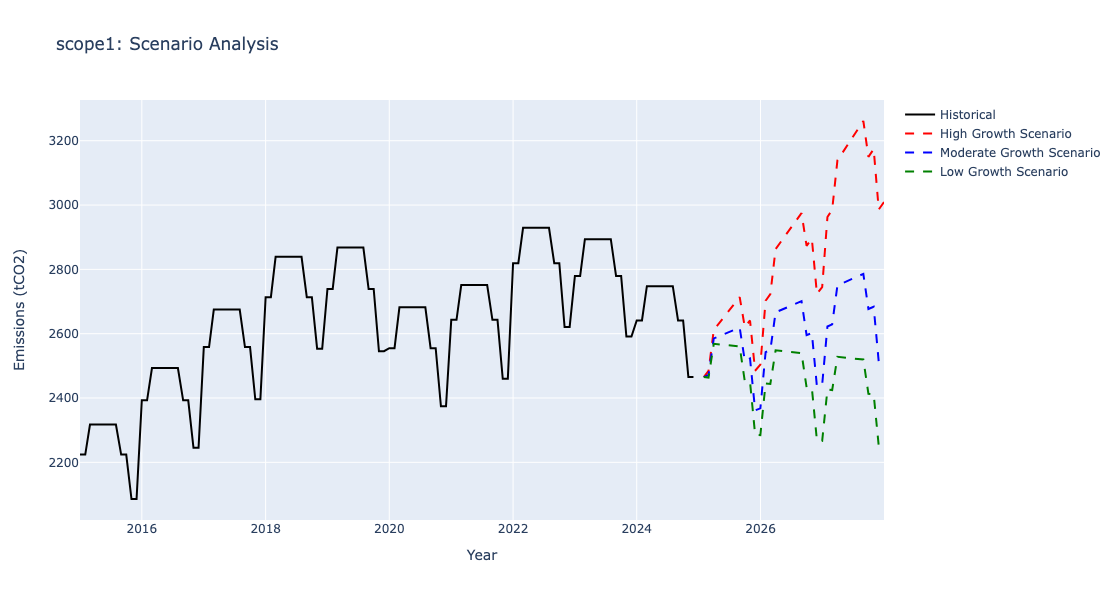

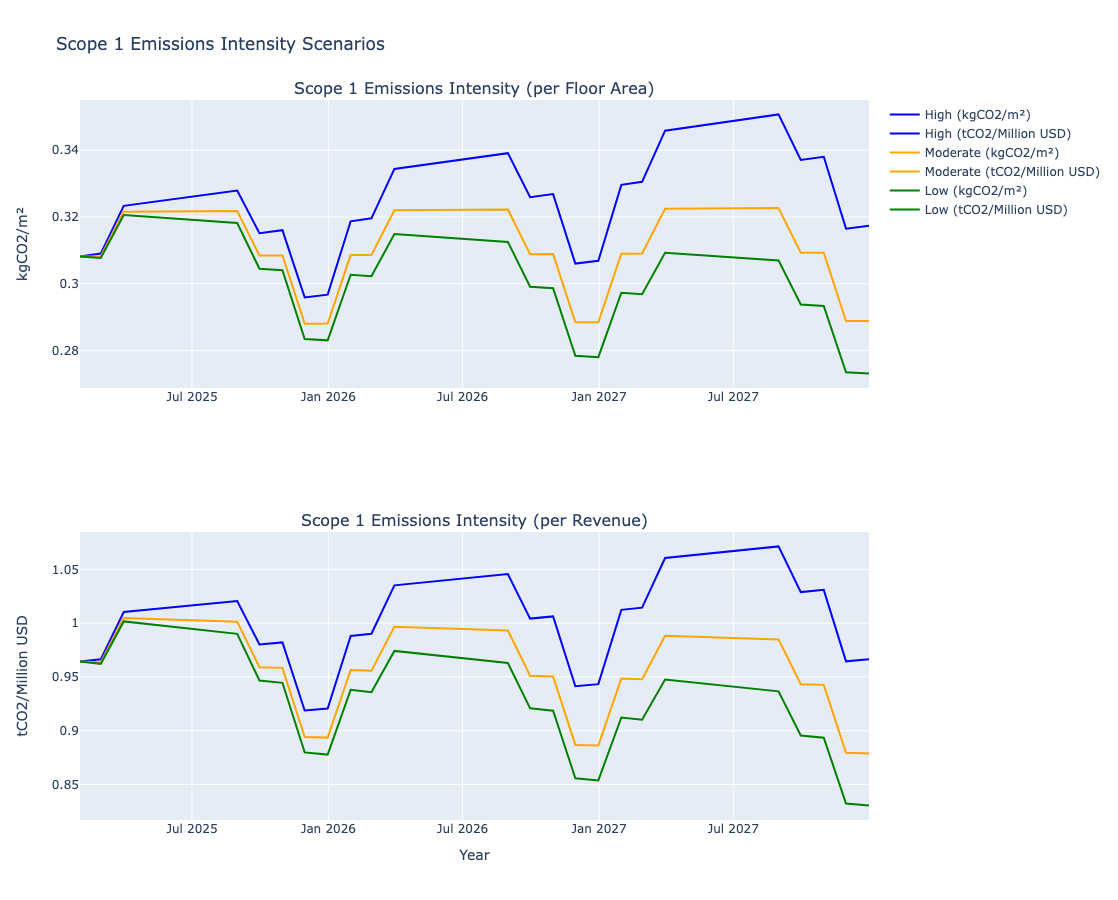

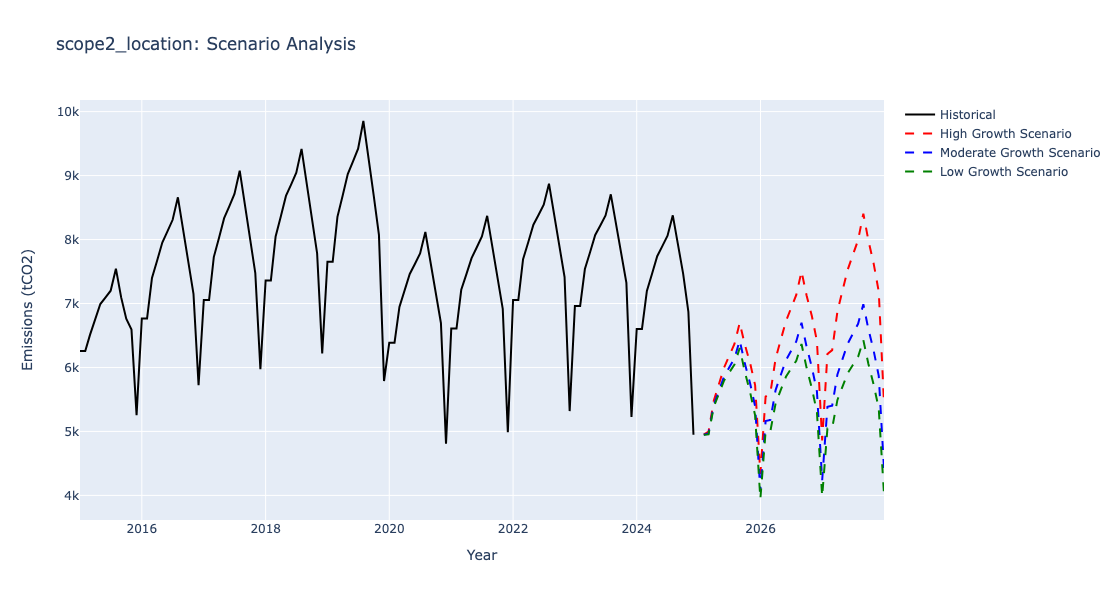

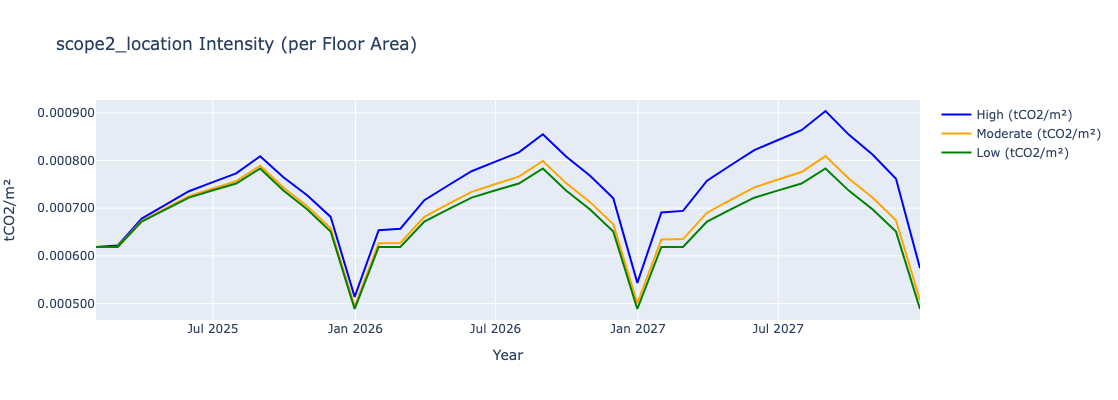

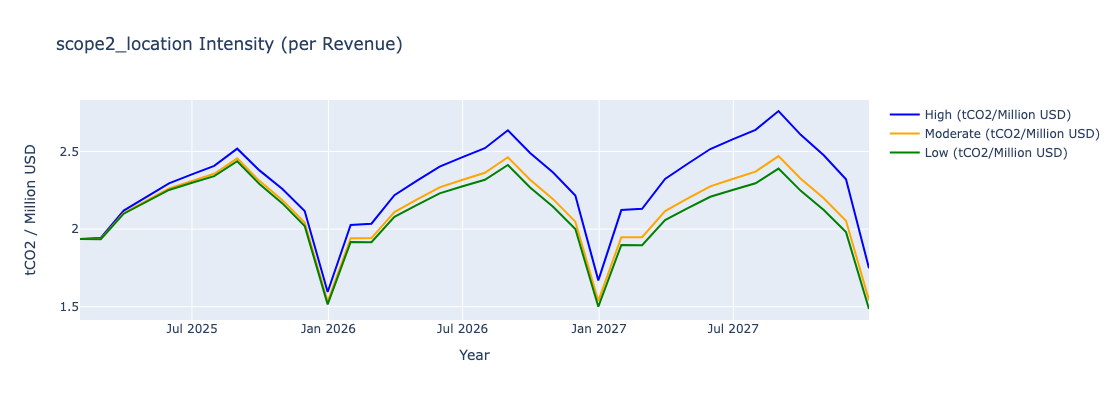


Scope 1 Summary:

Scenario Summary for scope1:
Scenario scope1 (last12 avg) vs. Base (%) Floorspace Revenue (B USD)  tCO2/m² tCO2/Million USD
    High             3,122.2       +26.7%  9,233,391            3.02 0.000338            1.034
Moderate             2,687.6        +9.0%  8,603,276            2.81 0.000312            0.955
     Low             2,443.2        -0.9%  8,198,136            2.68 0.000298            0.910
Scenario scope1 (last12 avg) vs. Base (%) Floorspace Revenue (B USD)  tCO2/m² tCO2/Million USD
    High             3,122.2       +26.7%  9,233,391            3.02 0.000338            1.034
Moderate             2,687.6        +9.0%  8,603,276            2.81 0.000312            0.955
     Low             2,443.2        -0.9%  8,198,136            2.68 0.000298            0.910

Scope 2 Summary:

Scenario Summary for scope2_location:
Scenario scope2_location (last12 avg) vs. Base (%) Floorspace Revenue (B USD)  tCO2/m² tCO2/Million USD
    High                      7

In [6]:
def load_data(csv_file):
    try:
        df = pd.read_csv(csv_file)
        required_cols = ['Year', 'Month', 'Scope1', 'Scope2_Location', 'floorspace', 'revenue_BUSD']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
            
        df['date'] = pd.to_datetime(df[['Year','Month']].assign(Day=1))
        df.set_index('date', inplace=True)
        
        # Handle missing values for all numeric columns
        numeric_cols = ['revenue_BUSD', 'Scope1', 'Scope2_Location', 'floorspace']
        for col in numeric_cols:
            df[col] = df[col].replace(0, np.nan)
            df[col].fillna(method='ffill', inplace=True)
            df[col].fillna(method='bfill', inplace=True)
        
        return df
    except FileNotFoundError:
        raise FileNotFoundError(f"Could not find CSV file: {csv_file}")
    except Exception as e:
        raise ValueError(f"Error processing CSV file: {str(e)}")

def prepare_emissions_ts(df):
    """
    Creates a dictionary of time-series for both Scope 1 and Scope 2 emissions
    """
    emissions_ts = {
        'scope1': df['Scope1'],
        'scope2_location': df['Scope2_Location'],
        'floorspace': df['floorspace'],
        'revenue_busd': df['revenue_BUSD']
    }
    
    # Basic intensity calculations for both scopes
    scope1_int = df['Scope1'] / df['floorspace'].replace(0, np.nan)
    scope2_int = df['Scope2_Location'] / df['floorspace'].replace(0, np.nan)
    
    for intensity in [scope1_int, scope2_int]:
        intensity.replace([np.inf, -np.inf], np.nan, inplace=True)
        intensity.fillna(method='ffill', inplace=True)
    
    emissions_ts['scope1_intensity'] = scope1_int
    emissions_ts['scope2_intensity'] = scope2_int
    
    return emissions_ts
    

GROWTH_RATES = {
    'high': {
        'floorspace': 0.06,
        'revenue': 0.07,
        'efficiency_improve': 0.005,
        'emissions_ratio': 0.99
    },
    'moderate': {
        'floorspace': 0.03,
        'revenue': 0.04,
        'efficiency_improve': 0.01,
        'emissions_ratio': 0.995
    },
    'low': {
        'floorspace': 0.01,
        'revenue': 0.02,
        'efficiency_improve': 0.015,
        'emissions_ratio': 0.998
    }
}


def generate_scenario_data(emissions_ts, scenario='moderate', periods=36, emissions_type='scope1'):
    """Generate emissions scenarios with validation."""
    if scenario not in GROWTH_RATES:
        raise ValueError(f"Invalid scenario: {scenario}. Must be one of {list(GROWTH_RATES.keys())}")
        
    if emissions_type not in ['scope1', 'scope2_location']:
        raise ValueError(f"Invalid emissions_type: {emissions_type}. Must be 'scope1' or 'scope2_location'")
    
    rates = GROWTH_RATES[scenario]
    
    # Get last historical values
    last_idx = emissions_ts[emissions_type].index[-1]
    emissions_val = emissions_ts[emissions_type].iloc[-1]
    fs_val = emissions_ts['floorspace'].iloc[-1]
    rev_val = emissions_ts['revenue_busd'].iloc[-1]
    
    # Calculate historical trend and seasonality
    historical = emissions_ts[emissions_type]
    seasonal_pattern = historical.groupby(historical.index.month).mean()
    overall_mean = historical.mean()
    seasonal_factors = seasonal_pattern / overall_mean
    
    # Calculate monthly rates
    monthly_fs_growth = (1 + rates['floorspace'])**(1/12) - 1
    monthly_rev_growth = (1 + rates['revenue'])**(1/12) - 1
    monthly_eff_improve = (1 + rates['efficiency_improve'])**(1/12) - 1
    monthly_emissions_ratio = rates['emissions_ratio']**(1/12)
    
    # Set up scenario parameters (same as before)
    if emissions_type == 'scope1':
        if scenario == 'high':
            correlation_factor_fs = 0.9
            correlation_factor_rev = 0.6
            efficiency_reduction = 0.2
        elif scenario == 'moderate':
            correlation_factor_fs = 0.65
            correlation_factor_rev = 0.4
            efficiency_reduction = 0.4
        else:  # low
            correlation_factor_fs = 0.2
            correlation_factor_rev = 0.1
            efficiency_reduction = 0.8
    else:  # scope2_location
        if scenario == 'high':
            correlation_factor_fs = 1.2
            correlation_factor_rev = 0.8
            efficiency_reduction = 0.05
        elif scenario == 'moderate':
            correlation_factor_fs = 0.8
            correlation_factor_rev = 0.6
            efficiency_reduction = 0.15
        else:  # low
            correlation_factor_fs = 0.4
            correlation_factor_rev = 0.4
            efficiency_reduction = 0.25
    
    # Create future dates and initialize DataFrame
    future_dates = pd.date_range(start=last_idx + pd.offsets.MonthBegin(1),
                                periods=periods, freq='M')
    
    scenario_df = pd.DataFrame(index=future_dates, 
                             columns=['floorspace', 'revenue_busd', emissions_type])
    
    # Important: Set the first row to match the last historical values exactly
    scenario_df.iloc[0] = [fs_val, rev_val, emissions_val]
    
    # Generate scenario data starting from the second month
    for i in range(1, len(future_dates)):
        # Get previous values
        old_fs = scenario_df.iloc[i-1]['floorspace']
        old_rev = scenario_df.iloc[i-1]['revenue_busd']
        old_emissions = scenario_df.iloc[i-1][emissions_type]
        
        # Calculate new values
        new_fs = old_fs * (1 + monthly_fs_growth)
        new_rev = old_rev * (1 + monthly_rev_growth)
        
        # Calculate growth impacts
        fs_increase_frac = (new_fs - old_fs) / old_fs
        rev_increase_frac = (new_rev - old_rev) / old_rev
        
        # Calculate new emissions
        if emissions_type == 'scope1':
            new_emissions = old_emissions * (1 - monthly_eff_improve * efficiency_reduction)
        else:  # scope2_location
            new_emissions = old_emissions * monthly_emissions_ratio
        
        # Apply growth correlations
        new_emissions *= (1 + correlation_factor_fs*fs_increase_frac
                         + correlation_factor_rev*rev_increase_frac)
        
        # Apply seasonal factor
        month = future_dates[i].month
        new_emissions *= seasonal_factors[month] / seasonal_factors[future_dates[i-1].month]
        
        # Store values
        scenario_df.iloc[i] = [new_fs, new_rev, new_emissions]
    
    return scenario_df


def plot_scenario_emissions(emissions_ts, scenario_dfs, emissions_col='scope2_location'):
    """ 
    Similar to the Scope1 plotting, but for scope2 or any chosen column. 
    """
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=emissions_ts[emissions_col].index,
            y=emissions_ts[emissions_col].values,
            name='Historical',
            line=dict(color='black')
        )
    )

    colors = {'high':'red','moderate':'blue','low':'green'}
    for scenario, df in scenario_dfs.items():
        fig.add_trace(
            go.Scatter(
                x=df.index,
                y=df[emissions_col],
                name=f'{scenario.capitalize()} Growth Scenario',
                line=dict(color=colors[scenario], dash='dash')
            )
        )

    fig.update_layout(
        title=f'{emissions_col}: Scenario Analysis',
        xaxis_title='Year',
        yaxis_title='Emissions (tCO2)',
        height=600,
        width=1000,
        showlegend=True
    )
    fig.show()
    fig.write_image("2_company_images/company_dashboard_6.png")

def plot_scenario_intensity(scenario_dfs, emissions_col='scope2_location'):
    fig = go.Figure()

    color_map_fs = {'high':'blue','moderate':'orange','low':'green'}
    color_map_rev = {'high':'blue','moderate':'orange','low':'green'}

    # 1) Emissions per floor area
    fig1 = go.Figure()
    for scenario, df in scenario_dfs.items():
        e_per_area = df[emissions_col] / df['floorspace']
        fig1.add_trace(go.Scatter(
            x=df.index,
            y=e_per_area,
            mode='lines',
            name=f'{scenario.capitalize()} (tCO2/m²)',
            line=dict(color=color_map_fs[scenario])
        ))
    fig1.update_layout(
        title=f'{emissions_col} Intensity (per Floor Area)',
        xaxis_title='Year',
        yaxis_title='tCO2/m²',
        height=400, width=700,
        showlegend=True,
        yaxis=dict(tickformat='.6f')
    )
    fig1.show()
    fig.write_image("2_company_images/company_dashboard_7.png")

    # 2) Emissions per revenue
    fig2 = go.Figure()
    for scenario, df in scenario_dfs.items():
        # tCO2 / (million USD) => multiply revenue_BUSD by 1000 to get million
        e_per_revenue = (df[emissions_col] / (df['revenue_busd']*1000)).clip(lower=1e-9)
        fig2.add_trace(go.Scatter(
            x=df.index,
            y=e_per_revenue,
            mode='lines',
            name=f'{scenario.capitalize()} (tCO2/Million USD)',
            line=dict(color=color_map_rev[scenario])
        ))
    fig2.update_layout(
        title=f'{emissions_col} Intensity (per Revenue)',
        xaxis_title='Year',
        yaxis_title='tCO2 / Million USD',
        height=400, width=700,
        showlegend=True
    )
    fig2.show()
    fig.write_image("2_company_images/company_dashboard_8.png")

def plot_intensity_charts(scenario_dict):
    try:
        from plotly.subplots import make_subplots
        
        fig = make_subplots(
            rows=2, cols=1, 
            subplot_titles=('Scope 1 Emissions Intensity (per Floor Area)',
                          'Scope 1 Emissions Intensity (per Revenue)'),
            vertical_spacing=0.2
        )
        
        color_map = {'high':'blue', 'moderate':'orange', 'low':'green'}
        
        for scenario, df in scenario_dict.items():
            required_cols = ['floorspace', 'revenue_busd', 'scope1']
            if not all(col in df.columns for col in required_cols):
                raise ValueError(f"Missing required columns for scenario {scenario}")
                
            floorspace = df['floorspace'].clip(lower=1e-6)
            revenue = df['revenue_busd'].clip(lower=1e-6)
            scope1 = df['scope1'].clip(lower=1e-6)
            
            # Floor area intensity (kgCO2/m²)
            intensity_fs = (scope1 / floorspace) * 1000
            fig.add_trace(
                go.Scatter(x=df.index, y=intensity_fs,
                          name=f'{scenario.capitalize()} (kgCO2/m²)',
                          line=dict(color=color_map[scenario])),
                row=1, col=1
            )
            
            # Revenue intensity (tCO2/Million USD)
            intensity_rev = scope1 / (revenue * 1000)
            fig.add_trace(
                go.Scatter(x=df.index, y=intensity_rev,
                          name=f'{scenario.capitalize()} (tCO2/Million USD)',
                          line=dict(color=color_map[scenario])),
                row=2, col=1
            )
        
        fig.update_layout(
            height=900,
            width=1000,
            showlegend=True,
            title_text="Scope 1 Emissions Intensity Scenarios"
        )
        
        fig.update_xaxes(title_text="Year", row=2, col=1)
        fig.update_yaxes(title_text="kgCO2/m²", row=1, col=1)
        fig.update_yaxes(title_text="tCO2/Million USD", row=2, col=1)
        
        fig.show()
        fig.write_image("2_company_images/company_dashboard_9.png")
    except Exception as e:
        print(f"Error plotting intensity charts: {str(e)}")


def scenario_summary_table(scenario_dfs, base_emissions, emissions_col='scope2_location'):
    summary = []
    for scenario, df in scenario_dfs.items():
        last_12 = df.iloc[-12:]
        avg_emissions = last_12[emissions_col].mean()

        floorspace_avg = last_12['floorspace'].mean()
        revenue_avg = last_12['revenue_busd'].mean()

        # Fix intensity calculations
        e_per_m2 = (avg_emissions / floorspace_avg)
        e_per_rev = (avg_emissions / (revenue_avg * 1000))

        pct_diff = (avg_emissions - base_emissions)/base_emissions * 100

        summary.append({
            'Scenario': scenario.capitalize(),
            f'{emissions_col} (last12 avg)': f"{avg_emissions:,.1f}",
            'vs. Base (%)': f"{pct_diff:+.1f}%",
            'Floorspace': f"{floorspace_avg:,.0f}",
            'Revenue (B USD)': f"{revenue_avg:.2f}",
            'tCO2/m²': f"{e_per_m2:.6f}",
            'tCO2/Million USD': f"{e_per_rev:.3f}"
        })

    summ_df = pd.DataFrame(summary)
    print(f"\nScenario Summary for {emissions_col}:")
    print(summ_df.to_string(index=False))
    return summ_df


if __name__ == "__main__":
    csv_file = "real_estate_company.csv"
    df = load_data(csv_file)
    
    # Prep time-series
    emissions_ts = prepare_emissions_ts(df)
    
    # Generate scenarios for both scopes
    scenario_names = ['high','moderate','low']
    scope1_scenarios = {}
    scope2_scenarios = {}
    
    # Get baseline values
    base_scope1_val = emissions_ts['scope1'].iloc[-1]
    base_scope2_val = emissions_ts['scope2_location'].iloc[-1]
    
    # Generate scenarios for both scopes
    for scenario in scenario_names:
        # Scope 1 scenarios
        scope1_df = generate_scenario_data(emissions_ts, scenario, periods=36, emissions_type='scope1')
        scope1_scenarios[scenario] = scope1_df
        
        # Scope 2 scenarios
        scope2_df = generate_scenario_data(emissions_ts, scenario, periods=36, emissions_type='scope2_location')
        scope2_scenarios[scenario] = scope2_df
    
    # Plot Scope 1
    plot_scenario_emissions(emissions_ts, scope1_scenarios, emissions_col='scope1')
    plot_intensity_charts(scope1_scenarios)
    
    # Plot Scope 2
    plot_scenario_emissions(emissions_ts, scope2_scenarios, emissions_col='scope2_location') 
    plot_scenario_intensity(scope2_scenarios, emissions_col='scope2_location')
    
    # Print summaries
    print("\nScope 1 Summary:")
    scope1_summary = scenario_summary_table(scope1_scenarios, base_scope1_val, emissions_col='scope1')
    print(scope1_summary.to_string(index=False))
    
    print("\nScope 2 Summary:")
    scope2_summary = scenario_summary_table(scope2_scenarios, base_scope2_val, emissions_col='scope2_location')
    print(scope2_summary.to_string(index=False))


Company data sample:
            Year  Month   Scope1  Scope2_Location  Scope2_Market  Scope3_Cat1  \
date                                                                            
2015-01-31  2015      1  2224.12          6256.33        5211.28     21844.76   
2015-02-28  2015      2  2224.12          6256.33        5211.28     21844.76   
2015-03-31  2015      3  2317.36          6509.81        5425.09     23079.21   
2015-04-30  2015      4  2317.36          6750.69        5630.56     24012.81   
2015-05-31  2015      5  2317.36          6991.58        5836.04     24946.41   

            Scope3_Cat2  Scope3_Cat3  Scope3_Cat5  Scope3_Cat6  Scope3_Cat7  \
date                                                                          
2015-01-31     26222.26      7282.00      2184.48       218.45       436.90   
2015-02-28     26222.26      7282.00      2184.48       218.45       436.90   
2015-03-31     24374.78      7692.98      2307.97       230.80       461.59   
2015-04-30     

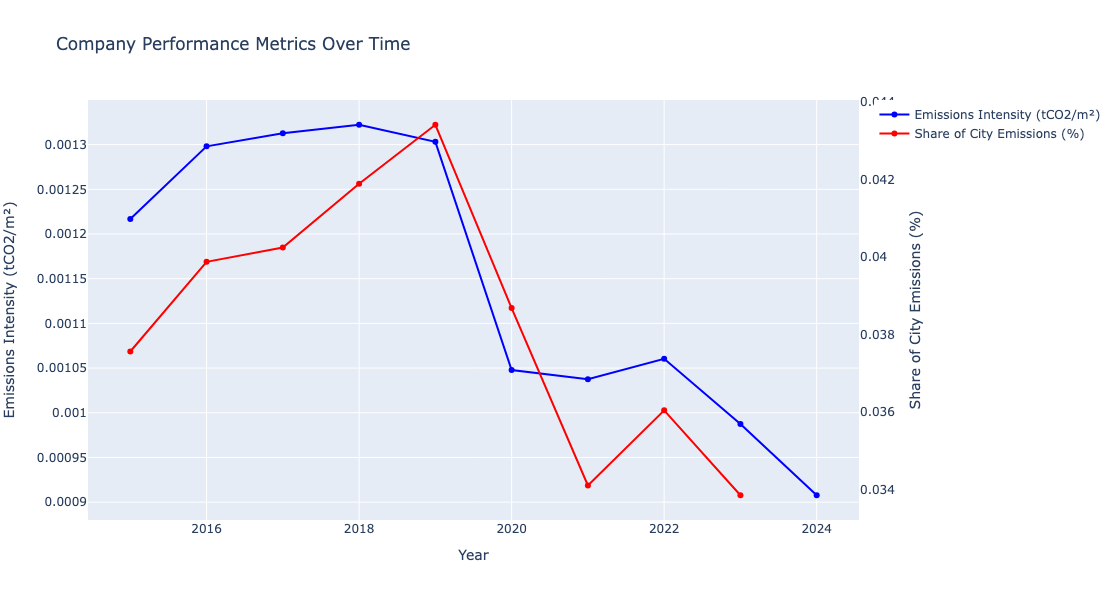


Benchmarking Metrics Summary:

Emissions Intensity:
  Current: 0.0009 tCO2/m²
  Change since 2015: -25.4%

Share of City Emissions:
  Current: nan%
  Change since 2015: +nan percentage points

Grid Performance:
  Grid intensity change: +nan%
  Company vs Grid: +nan% (negative means better than grid)
Correlation( Scope2_Location, EnergyRequirement_GWh )= 0.096
Correlation( Scope2_Location, CarbonIntensity_Combined_tCO2_per_MWh )= -0.068


In [7]:
def load_dewa_data(csv_file):
    try:
        # Read CSV with 'N/A' as NaN
        df = pd.read_csv(csv_file, na_values=['N/A'], thousands=',')
        print("\nOriginal columns in DEWA data:", df.columns.tolist())
        
        # Convert Year to datetime for proper indexing
        df['date'] = pd.to_datetime(df['Year'].astype(str), format='%Y')
        df.set_index('date', inplace=True)
        
        # Print date range of data
        print(f"\nDEWA data date range: {df.index.min()} to {df.index.max()}")
        
        # Print available columns and their non-null counts
        print("\nColumn info in DEWA data:")
        print(df.info())
        
        # Handle missing values with forward fill then backward fill
        df = df.ffill().bfill()
        
        print("\nSample of processed DEWA data:")
        print(df.head())
        
        required_columns = ['EnergyRequirement_GWh', 'CarbonIntensity_Combined_tCO2_per_MWh']
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
            
        return df
    except Exception as e:
        print(f"Error loading DEWA data: {str(e)}")
        return None

def integrate_dewa_data(company_df, dewa_df, scale_factor=0.05):
    try:
        # Create a copy to avoid modifying original dataframes
        company_df = company_df.copy()
        dewa_df = dewa_df.copy()
        
        # Print date ranges to debug alignment
        print(f"\nCompany data date range: {company_df.index.min()} to {company_df.index.max()}")
        print(f"DEWA data date range: {dewa_df.index.min()} to {dewa_df.index.max()}")
        
        # Drop the Year column from dewa_df since we're using date index
        if 'Year' in dewa_df.columns:
            dewa_df = dewa_df.drop('Year', axis=1)
        
        # Create a year column for merging
        company_df['merge_year'] = company_df.index.year
        dewa_df['merge_year'] = dewa_df.index.year
        
        print("\nUnique years in company data:", sorted(company_df['merge_year'].unique()))
        print("Unique years in DEWA data:", sorted(dewa_df['merge_year'].unique()))
        
        # Merge on year instead of exact dates
        merged = pd.merge(
            company_df,
            dewa_df.reset_index(drop=True),
            on='merge_year',
            how='left'
        )
        
        # Drop the merge column
        merged = merged.drop('merge_year', axis=1)
        
        print("\nMerged data shape:", merged.shape)
        print("Merged columns:", merged.columns.tolist())
        
        # Check for any missing values in key columns
        key_cols = ['EnergyRequirement_GWh', 'CarbonIntensity_Combined_tCO2_per_MWh']
        for col in key_cols:
            if col in merged.columns:
                missing = merged[col].isna().sum()
                print(f"\nMissing values in {col}: {missing}")
                if missing > 0:
                    print(f"Years with missing {col}:", 
                          sorted(merged[merged[col].isna()]['Year'].unique()))
        
        return merged
    except Exception as e:
        print(f"Error integrating DEWA data: {str(e)}")
        return None

def check_correlation_with_dewa(merged_df, scope2_col='Scope2_Location'):
    if 'EnergyRequirement_GWh' in merged_df.columns:
        # Drop NaN values for correlation calculation
        valid_data = merged_df[[scope2_col, 'EnergyRequirement_GWh']].dropna()
        if not valid_data.empty:
            corr_consumption = valid_data.corr().iloc[0,1]
            print(f"Correlation( {scope2_col}, EnergyRequirement_GWh )= {corr_consumption:.3f}")
        else:
            print("No valid data pairs for correlation with EnergyRequirement_GWh")
    
    if 'CarbonIntensity_Combined_tCO2_per_MWh' in merged_df.columns:
        # Drop NaN values for correlation calculation
        valid_data = merged_df[[scope2_col, 'CarbonIntensity_Combined_tCO2_per_MWh']].dropna()
        if not valid_data.empty:
            corr_intensity = valid_data.corr().iloc[0,1]
            print(f"Correlation( {scope2_col}, CarbonIntensity_Combined_tCO2_per_MWh )= {corr_intensity:.3f}")
        else:
            print("No valid data pairs for correlation with CarbonIntensity_Combined_tCO2_per_MWh")

def calculate_benchmarking_metrics(merged_df):
    try:
        # Calculate annual metrics
        annual_data = []
        
        for year in sorted(merged_df['Year'].unique()):
            year_data = merged_df[merged_df['Year'] == year]
            if year_data.empty or year_data['Scope2_Location'].isna().all():
                continue
                
            # Calculate metrics
            company_emissions = year_data['Scope2_Location'].mean()
            company_intensity = company_emissions / year_data['floorspace'].iloc[0]
            city_emissions = year_data['Electricity_Generation_tCO2'].mean()
            grid_intensity = year_data['CarbonIntensity_Elec_tCO2_per_MWh'].mean()
            
            # Store annual metrics
            annual_data.append({
                'Year': year,
                'Company_Intensity': company_intensity,
                'Company_Emissions': company_emissions,
                'City_Emissions': city_emissions,
                'Grid_Intensity': grid_intensity,
                'Share_of_City': (company_emissions / city_emissions * 100) if city_emissions else None
            })
        
        annual_df = pd.DataFrame(annual_data)
        
        # Create visualization
        fig = go.Figure()
        
        # 1. Company's emissions intensity trend
        fig.add_trace(go.Scatter(
            x=annual_df['Year'],
            y=annual_df['Company_Intensity'],
            name='Emissions Intensity (tCO2/m²)',
            line=dict(color='blue', width=2),
            yaxis='y'
        ))
        
        # 2. Share of city emissions trend
        fig.add_trace(go.Scatter(
            x=annual_df['Year'],
            y=annual_df['Share_of_City'],
            name='Share of City Emissions (%)',
            line=dict(color='red', width=2),
            yaxis='y2'
        ))
        
        # Update layout with dual y-axes
        fig.update_layout(
            title='Company Performance Metrics Over Time',
            xaxis_title='Year',
            yaxis=dict(
                title='Emissions Intensity (tCO2/m²)',
                side='left',
                showgrid=True
            ),
            yaxis2=dict(
                title='Share of City Emissions (%)',
                side='right',
                overlaying='y',
                showgrid=False
            ),
            height=600,
            width=1000,
            showlegend=True,
            hovermode='x unified'
        )
        
        fig.show()
        fig.write_image("2_company_images/company_dashboard_10.png")
        
        # Calculate year-over-year changes
        baseline_year = annual_df['Year'].min()
        latest_year = annual_df['Year'].max()
        
        baseline_data = annual_df[annual_df['Year'] == baseline_year].iloc[0]
        latest_data = annual_df[annual_df['Year'] == latest_year].iloc[0]
        
        intensity_change = ((latest_data['Company_Intensity'] / baseline_data['Company_Intensity']) - 1) * 100
        share_change = latest_data['Share_of_City'] - baseline_data['Share_of_City']
        grid_intensity_change = ((latest_data['Grid_Intensity'] / baseline_data['Grid_Intensity']) - 1) * 100
        
        # Print comprehensive benchmarking summary
        print("\nBenchmarking Metrics Summary:")
        print(f"\nEmissions Intensity:")
        print(f"  Current: {latest_data['Company_Intensity']:.4f} tCO2/m²")
        print(f"  Change since {baseline_year}: {intensity_change:+.1f}%")
        
        print(f"\nShare of City Emissions:")
        print(f"  Current: {latest_data['Share_of_City']:.4f}%")
        print(f"  Change since {baseline_year}: {share_change:+.4f} percentage points")
        
        print(f"\nGrid Performance:")
        print(f"  Grid intensity change: {grid_intensity_change:+.1f}%")
        print(f"  Company vs Grid: {intensity_change - grid_intensity_change:+.1f}% (negative means better than grid)")
        
        return merged_df
        
    except Exception as e:
        print(f"Error calculating benchmarking metrics: {str(e)}")
        traceback.print_exc()
        return None

if __name__ == "__main__":
    try:
        # 1) Load your real estate dataset
        company_df = pd.read_csv('real_estate_company.csv')
        
        # Create proper datetime index for company data
        company_df['date'] = pd.to_datetime(company_df[['Year', 'Month']].assign(Day=1))
        company_df['date'] = company_df['date'] + pd.offsets.MonthEnd(0)
        company_df.set_index('date', inplace=True)
        
        print("\nCompany data sample:")
        print(company_df.head())
        
        # Make sure revenue_BUSD is forward-filled if missing
        company_df['revenue_BUSD'] = company_df['revenue_BUSD'].replace(0, np.nan).ffill().fillna(1e-3)

        # 2) Load DEWA dataset
        dewa_df = load_dewa_data('UAE_Emissions_Macro.csv')
        if dewa_df is None:
            raise ValueError("Failed to load DEWA data")
        
        # 3) Merge them
        merged = integrate_dewa_data(company_df, dewa_df, scale_factor=0.05)
        if merged is None:
            raise ValueError("Failed to integrate data")
            
        if merged.empty:
            raise ValueError("No data after merging! Check date alignments.")
        
        # 4) Calculate benchmarking metrics
        print("\nCalculating benchmarking metrics...")
        merged = calculate_benchmarking_metrics(merged)
        if merged is None:
            raise ValueError("Failed to calculate benchmarking metrics")
        
        # 5) Check correlation 
        check_correlation_with_dewa(merged, scope2_col='Scope2_Location')
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        traceback.print_exc()
